In [152]:
from astropy.io import fits
import reproject
from astropy import convolution
from astropy.convolution import Gaussian2DKernel
from astropy import units as u
from astropy.table import Table
import pyavm
import shutil

In [153]:
import regions
from astropy import coordinates

In [154]:
import PIL

In [155]:
from spectral_cube import SpectralCube, Projection, Slice

In [156]:
import uvcombine
from astropy import wcs

In [157]:
import scipy.ndimage

In [158]:
import matplotlib
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [159]:
import numpy as np

In [160]:
import pylab as pl
from astropy.visualization import simple_norm

In [161]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
tgt_wcs = wcs.WCS()
tgt_wcs.wcs.cdelt = [-1.74999921246059E-05, 1.74999921246059E-05]
tgt_wcs.wcs.crval = [266.53559994, -28.7129638]#266.5354004, -28.7129113]
tgt_wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']
tgt_wcs.naxis = [2323, 5769]#[int(0.045 / np.abs(tgt_wcs.wcs.cdelt[0])), int(0.103 / np.abs(tgt_wcs.wcs.cdelt[1]))]
tgt_wcs._naxis = [2323, 5769]#[int(0.045 / np.abs(tgt_wcs.wcs.cdelt[0])), int(0.103 / np.abs(tgt_wcs.wcs.cdelt[1]))]
tgt_wcs.wcs.crpix = np.array(tgt_wcs.naxis) / 2
tgt_header = tgt_wcs.to_header()
tgt_header['NAXIS'] = 2
tgt_header['NAXIS1'] = tgt_wcs.naxis[0]
tgt_header['NAXIS2'] = tgt_wcs.naxis[1]
tgt_header

#tgt_header = fits.getheader(f"{basepath}/images/last2022version/jw02221-o001_t001_nircam_clear-f410m_i2d.fits", ext=1)
#tgt_header

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1161.5 / Pixel coordinate of reference point            
CRPIX2  =               2884.5 / Pixel coordinate of reference point            
CDELT1  = -1.7499992124606E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  1.7499992124606E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =         266.53559994 / [deg] Coordinate value at reference point      
CRVAL2  =          -28.7129638 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =          -28.71296

In [163]:
basepath = '/orange/adamginsburg/jwst/brick/'
image_filenames = {
"f182m": f"{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-merged-reproject_i2d.fits",
"f187n": f"{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-merged-reproject_i2d.fits",
"f212n": f"{basepath}/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged-reproject_i2d.fits",
"f405n": f"{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged-reproject_i2d.fits",
"f410m": f"{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged-reproject_i2d.fits",
"f466n": f"{basepath}/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged-reproject_i2d.fits",
}
repr410_image_filenames = {x: y.replace("i2d", "i2d_reprj_f410_tall") for x,y in image_filenames.items()}

In [164]:
for filtername in image_filenames:
    if not os.path.exists(repr410_image_filenames[filtername]):
        print(f"Reprojecting {filtername} {image_filenames[filtername]} to {repr410_image_filenames[filtername]}")
        result,_ = reproject.reproject_interp(image_filenames[filtername], tgt_header, hdu_in='SCI')
        hdu = fits.PrimaryHDU(data=result, header=tgt_header)
        hdu.writeto(repr410_image_filenames[filtername], overwrite=True)

In [165]:
AVM = pyavm.AVM.from_header(tgt_header)

In [220]:
def save_rgb(img, filename, avm=None, flip=-1):
    img = (img*256)
    img[img<0] = 0
    img[img>255] = 255
    img = img.astype('uint8')
    img = PIL.Image.fromarray(img[::flip,::,:])
    img.save(filename)
    if avm is not None:
        base = os.path.basename(filename)
        dir = os.path.dirname(filename)
        avmname = os.path.join(dir, 'avm_'+base)
        avm.embed(filename, avmname)
        shutil.move(avmname, filename)
    return img

In [221]:
rgb = np.array(
      [
          fits.getdata(repr410_image_filenames['f466n']),
          fits.getdata(repr410_image_filenames['f410m']),
          fits.getdata(repr410_image_filenames['f405n']),
       #fits.getdata(f"{basepath}/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged-reproject_i2d_reprj_f410.fits"),
       #fits.getdata(f"{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged-reproject_i2d_reprj_f410.fits"),
       #fits.getdata(f"{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged-reproject_i2d_reprj_f410.fits"),
      ]
).swapaxes(0,2)
#for layer in (0,1,2):
#    # desaturate stars (though this will whiten the edges!)
#    rgb[:,:,layer][np.isnan(rgb[:,:,layer])] = np.nanmax(rgb[:,:,layer])
#    rgb[:,:,layer][rgb[:,:,layer] == 0] = np.nanmax(rgb[:,:,layer])

In [222]:
rgb2 = np.array(
      [
          fits.getdata(repr410_image_filenames['f187n']),
          fits.getdata(repr410_image_filenames['f212n']),
          fits.getdata(repr410_image_filenames['f182m']),
       #fits.getdata("jw02221-o001_t001_nircam_clear-f187n_i2d_reprj_f410.fits"),
       #fits.getdata("jw02221-o001_t001_nircam_clear-f212n_i2d_reprj_f410.fits"),
       #fits.getdata("jw02221-o001_t001_nircam_clear-f182m_i2d_reprj_f410.fits"),
      ]
).swapaxes(0,2)

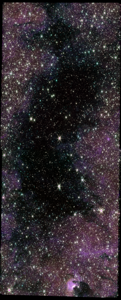

In [223]:
rgb_scaled = np.array([simple_norm(rgb[:,:,0], stretch='asinh', min_percent=1, max_percent=99.)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_percent=1, max_percent=99.)(rgb[:,:,1]),
                       simple_norm(rgb[:,:,2], stretch='asinh', min_percent=1, max_percent=99.)(rgb[:,:,2])]).swapaxes(0,2)

im = save_rgb(rgb_scaled, "BrickJWST_longwave_RGB_unrotated_tall.png", AVM)
im.thumbnail((300,300))
im

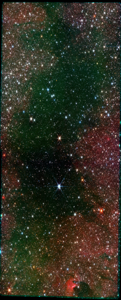

In [224]:
rgb_scaled = np.array([simple_norm(rgb[:,:,0], stretch='asinh', min_percent=1, max_percent=99.)(rgb[:,:,0]),
                       simple_norm(rgb2[:,:,1], stretch='asinh', min_percent=1, max_percent=99.)(rgb2[:,:,1]),
                       simple_norm(rgb2[:,:,2], stretch='asinh', min_percent=1, max_percent=99.)(rgb2[:,:,2])]).swapaxes(0,2)
outpng = "BrickJWST_RGB_466_212_182_tall.png"
im = save_rgb(rgb_scaled, outpng, AVM)
im.thumbnail((300,300))
im

In [225]:
fits.PrimaryHDU(data=rgb_scaled, header=tgt_header).writeto('rgb_466_410_405.fits', overwrite=True)

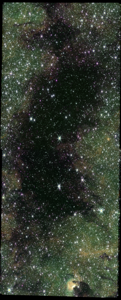

In [226]:
rgb_scaled = np.array([simple_norm(rgb[:,:,2], stretch='asinh', min_percent=0.1, max_percent=99.)(rgb[:,:,2]),
                       simple_norm(rgb[:,:,0], stretch='asinh', min_percent=0.1, max_percent=99.)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_percent=0.1, max_percent=99.)(rgb[:,:,1])]).swapaxes(0,2)
outpng = "BrickJWST_RGB_405_466_410_tall.png"
im = save_rgb(rgb_scaled, outpng, AVM)
im.thumbnail((300,300))
im

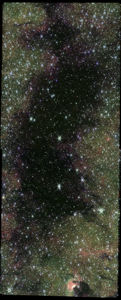

In [227]:
rgb_scaled = np.array([simple_norm(rgb[:,:,0], stretch='asinh', min_percent=0.1, max_percent=99.)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_percent=0.1, max_percent=99.)(rgb[:,:,1]),
                       simple_norm(rgb[:,:,2], stretch='asinh', min_percent=0.1, max_percent=99.)(rgb[:,:,2])]).swapaxes(0,2)
hsv = rgb_to_hsv(rgb_scaled)
hsv[:,:,0] += 0.25  # 0.25 = 90/360
hsv[:,:,0] = hsv[:,:,0] % 1 
rgb_scaled = hsv_to_rgb(hsv)
outpng = "BrickJWST_longwave_RGB_tall.png"
im = save_rgb(rgb_scaled, outpng, AVM)
im.thumbnail((300,300))
im

# Ice versions - starry & starless

In [228]:
import numpy as np

In [229]:
from astropy.io import fits
import reproject

In [230]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [231]:
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd

In [232]:
import pyavm
import numpy as np
from astropy import wcs
import PIL
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import pylab as pl
from astropy.visualization import simple_norm

In [233]:
wcs.WCS(fits.getheader(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_merged_destarred6.fits'))

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 266.53557808187 -28.71296769346 
CRPIX : 1174.6156255954 2851.4663520427 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -1.7473724308189e-05 1.7473724308189e-05 
NAXIS : 2350  5725

In [234]:
rgb = np.array(
      [
       fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_merged_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_merged_destarred6.fits'),
      ]
).swapaxes(0,2).swapaxes(0,1)
rgb2 = np.array( #TODO: need to reproject the 187-182 to 410
      [
       fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_merged_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_merged_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_merged_destarred6_reproj405.fits'),
      ]
).swapaxes(0,2).swapaxes(0,1)

In [235]:
AVM = pyavm.AVM.from_header(fits.getheader(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_merged_destarred6.fits'))

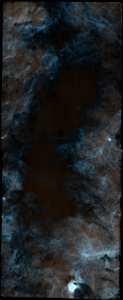

In [236]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=0, max_cut=90)(rgb[:,:,0]), # 466
                       simple_norm(narrowsum,  stretch='asinh', min_cut=0, max_cut=210)(narrowsum),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=0, max_cut=120)(rgb[:,:,1]), # 405
]
).swapaxes(0,2)

outfn = f"{basepath}/images/BrickJWST_merged_longwave_narrowband_redo.png"
save_rgb(rgb_scaled.swapaxes(0,1), outfn, flip=1, avm=AVM)
outfn = f"{basepath}/images/BrickJWST_merged_longwave_narrowband_flipped_redo.png"
im=save_rgb(rgb_scaled.swapaxes(0,1), outfn, flip=-1, avm=AVM)
im.thumbnail((300,300))
im

## starry

In [237]:
rgb_withstars = np.array(
      [
       fits.getdata(f'{basepath}/images/F466_refitted466wcsto410_merged-fortricolor.fits'),
       fits.getdata(f'{basepath}/images/F405_refitted405wcsto410_merged-fortricolor.fits'),
      ]
).swapaxes(0,2).swapaxes(0,1)

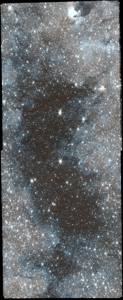

In [238]:
narrowsum_withstars = rgb_withstars[:,:,0] + rgb_withstars[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb_withstars[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb_withstars[:,:,0]),
                       simple_norm(narrowsum_withstars,  stretch='asinh', min_cut=-2, max_cut=210)(narrowsum_withstars),
                       simple_norm(rgb_withstars[:,:,1], stretch='asinh', min_cut=-1, max_cut=120)(rgb_withstars[:,:,1]),
]).swapaxes(0,2)

outfn = f"{basepath}/images/BrickJWST_merged_longwave_narrowband_withstars_redo.png"
im=save_rgb(rgb_scaled.swapaxes(0,1), outfn, flip=1, avm=AVM)
im.thumbnail((300,300))
im

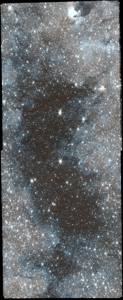

In [239]:
im = PIL.Image.open(f"{basepath}/images/BrickJWST_merged_longwave_narrowband_withstars_redo.png")
im.thumbnail((300,300))
im

# Add 1182

In [240]:
from astropy.coordinates import SkyCoord

In [241]:
tgt1182_wcs = wcs.WCS()
center = SkyCoord('17:46:08.5526', '-28:42:27.9273100698', frame='fk5', unit=(u.h, u.deg))
tgt1182_wcs.wcs.cdelt = [-1.74999921246059E-05, 1.74999921246059E-05]
tgt1182_wcs.wcs.crval = [center.ra.deg, center.dec.deg]
tgt1182_wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']
tgt1182_wcs.naxis = [2337, 5159]#[int(0.045 / np.abs(tgt1182_wcs.wcs.cdelt[0])), int(0.103 / np.abs(tgt1182_wcs.wcs.cdelt[1]))]
tgt1182_wcs._naxis = [2337, 5159]#[int(0.045 / np.abs(tgt1182_wcs.wcs.cdelt[0])), int(0.103 / np.abs(tgt1182_wcs.wcs.cdelt[1]))]
tgt1182_wcs.wcs.crpix = np.array(tgt1182_wcs.naxis) / 2
tgt1182_header = tgt1182_wcs.to_header()
tgt1182_header['NAXIS'] = 2
tgt1182_header['NAXIS1'] = tgt1182_wcs.naxis[0]
tgt1182_header['NAXIS2'] = tgt1182_wcs.naxis[1]
tgt1182_header

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1168.5 / Pixel coordinate of reference point            
CRPIX2  =               2579.5 / Pixel coordinate of reference point            
CDELT1  = -1.7499992124606E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  1.7499992124606E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =      266.53563583333 / [deg] Coordinate value at reference point      
CRVAL2  =      -28.70775758613 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =      -28.707757586

In [242]:
image_filenames_w1182 = {
"f182m": f"{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-merged-reproject_i2d.fits",
"f187n": f"{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-merged-reproject_i2d.fits",
"f212n": f"{basepath}/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged-reproject_i2d.fits",
"f405n": f"{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged-reproject_i2d.fits",
"f410m": f"{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged-reproject_i2d.fits",
"f466n": f"{basepath}/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged-reproject_i2d.fits",
"f444w": f"{basepath}/F444W/pipeline/jw01182-o004_t001_nircam_clear-f444w-merged-reproject_i2d.fits",
"f356w": f"{basepath}/F356W/pipeline/jw01182-o004_t001_nircam_clear-f356w-merged-reproject_i2d.fits",
"f200w": f"{basepath}/F200W/pipeline/jw01182-o004_t001_nircam_clear-f200w-merged-reproject_i2d.fits",
"f115w": f"{basepath}/F115W/pipeline/jw01182-o004_t001_nircam_clear-f115w-merged-reproject_i2d.fits",
}
repr1182_image_filenames = {x: y.replace("i2d", "i2d_reprj_1182p2221") for x,y in image_filenames_w1182.items()}

In [243]:
for filtername in image_filenames_w1182:
    if not os.path.exists(repr1182_image_filenames[filtername]):
        print(f"Reprojecting {filtername} {image_filenames_w1182[filtername]} to {repr1182_image_filenames[filtername]}")
        result,_ = reproject.reproject_interp(image_filenames_w1182[filtername], tgt1182_header, hdu_in='SCI')
        hdu = fits.PrimaryHDU(data=result, header=tgt1182_header)
        hdu.writeto(repr1182_image_filenames[filtername], overwrite=True)

In [244]:
rgb466_444_356 = np.array(
      [
          fits.getdata(repr1182_image_filenames['f466n']),
          fits.getdata(repr1182_image_filenames['f444w']),
          fits.getdata(repr1182_image_filenames['f356w']),
      ]
).swapaxes(0,2).swapaxes(0,1)

rgb444_405_356 = np.array(
      [
          fits.getdata(repr1182_image_filenames['f444w']),
          fits.getdata(repr1182_image_filenames['f405n']),
          fits.getdata(repr1182_image_filenames['f356w']),
      ]
).swapaxes(0,2).swapaxes(0,1)

In [245]:
AVM1182 = pyavm.AVM.from_header(tgt1182_header)
AVM1182.to_wcs().to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1168.5 / Pixel coordinate of reference point            
CRPIX2  =               2579.5 / Pixel coordinate of reference point            
CDELT1  = -1.7499992124606E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  1.7499992124606E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =      266.53563583333 / [deg] Coordinate value at reference point      
CRVAL2  =      -28.70775758613 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =      -28.707757586

In [246]:
AVM1182 = pyavm.AVM.from_header(tgt1182_header)
for filtercomb in (('f444w', 'f410m', 'f356w'),
                   ('f444w', 'f405n', 'f356w'),
                   ('f466n', 'f444w', 'f410m'),
                   ('f466n', 'f444w', 'f405n'),
                   ('f466n', 'f444w', 'f356w'),
                   ('f410m', 'f356w', 'f212n'),
                   ('f405n', 'f356w', 'f212n'),
                   ('f405n', 'f356w', 'f200w'),
                   ('f405n', 'f200w', 'f187n'),
                   ('f356w', 'f212n', 'f200w'),
                   ('f410m', 'f200w', 'f182m'),
                   ('f212n', 'f200w', 'f187n'),
                   ('f212n', 'f200w', 'f182m'),
                   ('f212n', 'f182m', 'f115w'),
                   ('f212n', 'f187n', 'f115w'),
                   ('f200w', 'f187n', 'f115w'),
                   ('f200w', 'f182m', 'f115w'),
                  ):
    f1,f2,f3 = filtercomb
    rgb = np.array(
          [
              fits.getdata(repr1182_image_filenames[f1]),
              fits.getdata(repr1182_image_filenames[f2]),
              fits.getdata(repr1182_image_filenames[f3]),
          ]
    ).swapaxes(0,2).swapaxes(0,1)
    
    rgb_scaled = np.array([
                           simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,0]),
                           simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,1]),
                           simple_norm(rgb[:,:,2], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,2]),
    ]).swapaxes(0,2)
    
    outfn = f"{basepath}/images/BrickJWST_1182p2221_{f1[1:-1]}_{f2[1:-1]}_{f3[1:-1]}.png"
    print(outfn)
    save_rgb(rgb_scaled.swapaxes(0,1), outfn, flip=-1, avm=AVM1182)

/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_444_410_356.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_444_405_356.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_466_444_410.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_466_444_405.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_466_444_356.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_410_356_212.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_405_356_212.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_405_356_200.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_405_200_187.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_356_212_200.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_410_200_182.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_212_200_187.png
/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_212_200_182.png
/orange/adam

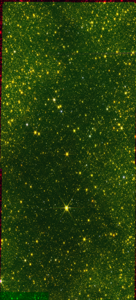

In [247]:
im = PIL.Image.open('/orange/adamginsburg/jwst/brick//images/BrickJWST_1182p2221_200_182_115.png')
im.thumbnail((300,300))
im